# Data preprocessing

In [134]:
# Importing libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# Data preprocessing
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [135]:
# Reading the dataset
df = pd.read_csv('/content/students_performance.csv')

In [136]:
# Calculating the overall score and dropping the course grades
df['overall_score'] = df[['math_score', 'reading_score', 'writing_score']].mean(axis=1)
df = df.drop(columns=['math_score', 'reading_score', 'writing_score'])

In [137]:
# changing the column name for race/ethnicity
df = df.rename(columns={'race/ethnicity': 'race_ethnicity'})

# Data analysis

In [138]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,overall_score
0,female,group B,bachelor's degree,standard,none,72.666667
1,female,group C,some college,standard,completed,82.333333
2,female,group B,master's degree,standard,none,92.666667
3,male,group A,associate's degree,free/reduced,none,49.333333
4,male,group C,some college,standard,none,76.333333


In [139]:
df.shape

(1000, 6)

In [140]:
# Checking for null values
df.isnull().sum()

gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
overall_score                  0
dtype: int64

In [141]:
# Summary statistics for numeric columns
df.describe()

,overall_score
count,1000.000000
mean,67.770667
std,14.257326
min,9.000000
25%,58.333333
50%,68.333333
75%,77.666667
max,100.000000


In [142]:
# Summary statistics for categorical columns
df.describe(include=['object'])

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course
count,1000,1000,1000,1000,1000
unique,2,5,6,2,2
top,female,group C,some college,standard,none
freq,518,319,226,645,642


In [143]:
# Unique values in categorical columns
for column in df.select_dtypes(include=['object']).columns:
    print('\n' + column)
    print(df[column].unique())


gender
['female' 'male']

race_ethnicity
['group B' 'group C' 'group A' 'group D' 'group E']

parental_level_of_education
["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']

lunch
['standard' 'free/reduced']

test_preparation_course
['none' 'completed']


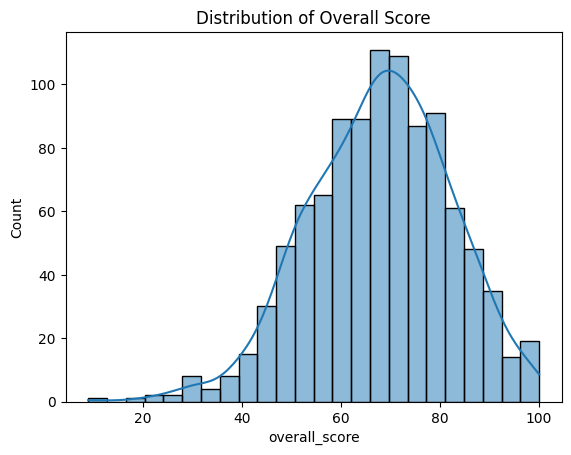

In [144]:
# Visualization of the distribution of the target variable
sns.histplot(df['overall_score'], kde=True)
plt.title('Distribution of Overall Score')
plt.show()

In [145]:
# Identifying outliers in overall_score and removing them
q1 = df['overall_score'].quantile(0.25)
q3 = df['overall_score'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df['overall_score'] >= lower_bound) & (df['overall_score'] <= upper_bound)]

# Model Training

In [146]:
# Defining categorical features
categorical_features = ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']
print(categorical_features)

['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']


In [147]:
# Encoding
df = pd.get_dummies(df, columns=categorical_features, dtype=int)

In [148]:
# Splitting the data into features and target
X = df.drop('overall_score', axis=1)
y = df['overall_score']

In [149]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R-squared:', r2_score(y_test, y_pred))
    return model

In [151]:
from sklearn.inspection import permutation_importance

def calculateFeatureImportance(model):
  # Calculate permutation importance
  perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

  # Extract feature importances and their standard deviations
  feature_names = X_train.columns
  importances = perm_importance.importances_mean
  std = perm_importance.importances_std

  # Create a DataFrame for easier visualization
  importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Std': std})

  # Sort the DataFrame by importance
  importance_df = importance_df.sort_values(by='Importance', ascending=False)

  print(importance_df)

  # Plot the feature importances
  plt.figure(figsize=(10, 6))
  plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'])
  plt.xlabel('Permutation Importance (negative MAE)')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()
  plt.show()

In [152]:
# For linear regression
def predict_manual(X, coef, intercept, fit_intercept):
    y_pred = np.dot(X, coef)
    if fit_intercept:
        y_pred += intercept
    return y_pred

# Function to evaluate the model
def evaluate_model_linear(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    coef = model.coef_
    intercept = model.intercept_
    fit_intercept = model.fit_intercept
    y_pred = predict_manual(X_test, coef, intercept, fit_intercept)
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('R-squared:', r2_score(y_test, y_pred))
    return model

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None}
Mean Absolute Error: 9.873953098827469
Mean Squared Error: 150.3814733389168
R-squared: 0.2240693695474566
                                           Feature    Importance           Std
1                                      gender_male  5.499127e+14  3.500471e+13
0                                    gender_female  5.499127e+14  3.500471e+13
14                                  lunch_standard  2.260451e+14  1.405620e+13
13                              lunch_free/reduced  2.260451e+14  1.405620e+13
7   parental_level_of_education_associate's degree  1.560687e+14  8.106495e+12
16                    test_preparation_course_none  1.443220e+14  7.915209e+12
15               test_preparation_course_completed  1.443220e+14  7.915209e+12
11        parental_level_of_education_some college  1.203515e+14  1.111724e+13
9          parental_level_of_education_high school  1.180221e+14  

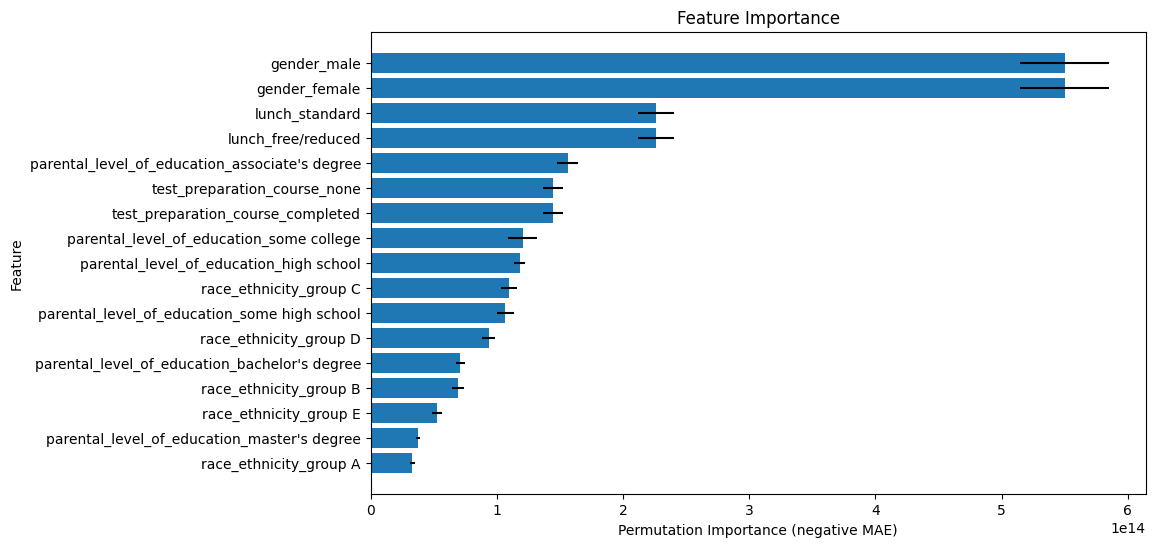

In [153]:
# Linear Regression
lr_model = LinearRegression()

param_grid_lr = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1]
}

lr_search = GridSearchCV(lr_model, param_grid_lr, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
lr_search.fit(X_train, y_train)
lr_best_model = lr_search.best_estimator_
print(lr_search.best_params_)
evaluate_model_linear(lr_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(lr_best_model)
# 9.873953098827469
# 9.876465661641541

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
Mean Absolute Error: 10.182757747262324
Mean Squared Error: 159.9511247781299
R-squared: 0.17469237177257113
                                           Feature  Importance       Std
14                                  lunch_standard    3.361714  0.431204
15               test_preparation_course_completed    2.926579  0.208888
5                           race_ethnicity_group D    2.065525  0.244521
0                                    gender_female    1.955547  0.462495
7   parental_level_of_education_associate's degree    1.759581  0.337998
1                                      gender_male    1.422242  0.303337
11        parental_level_of_education_some college    1.375687  0.270029
6                           race_ethnicity_group E    1.270863  0.252029
4                           race_ethnicity_group C    1.239043  0.285831
16

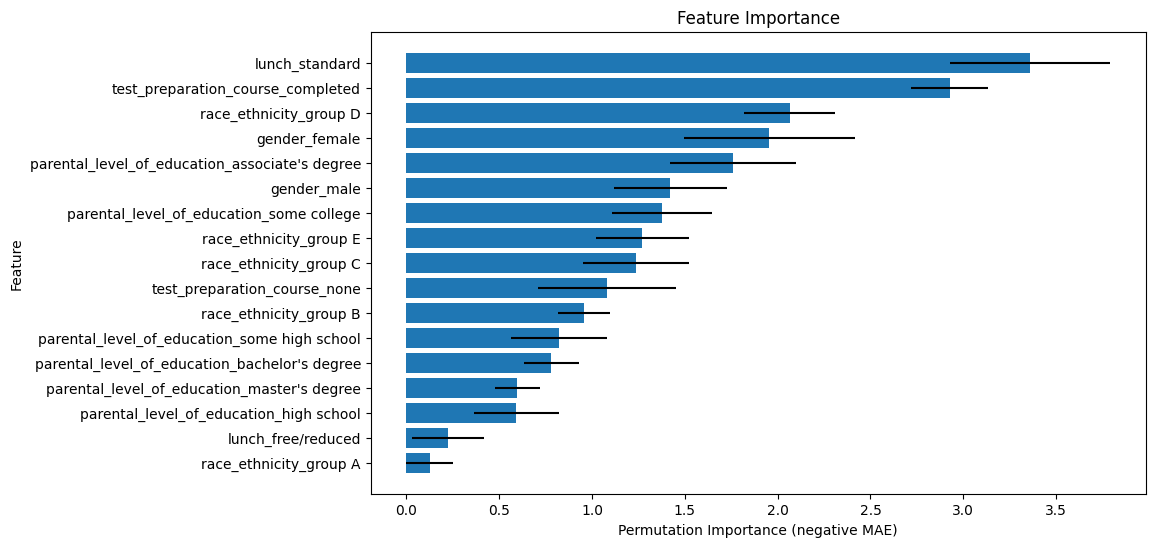

In [154]:
# Neural Network
nn_model = MLPRegressor(random_state=42, max_iter=2000, early_stopping=True, n_iter_no_change=10)

param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

nn_search = RandomizedSearchCV(nn_model, param_grid_nn, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
nn_search.fit(X_train, y_train)
nn_best_model = nn_search.best_estimator_
print(nn_search.best_params_)
evaluate_model(nn_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(nn_best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
Mean Absolute Error: 9.961199947338008
Mean Squared Error: 153.24161292354634
R-squared: 0.20931176768461102
                                           Feature  Importance       Std
13                              lunch_free/reduced    0.905486  0.162495
15               test_preparation_course_completed    0.453092  0.091965
0                                    gender_female    0.080722  0.112087
9          parental_level_of_education_high school    0.078604  0.087399
10     parental_level_of_education_master's degree    0.055696  0.037589
2                           race_ethnicity_group A    0.054283  0.035475
6                           race_ethnicity_group E    0.045788  0.047276
12    parental_level_of_education_some high school    0.039797  0.043117
5                           race_ethnicity_group D    0.023636  0.015871
3                    

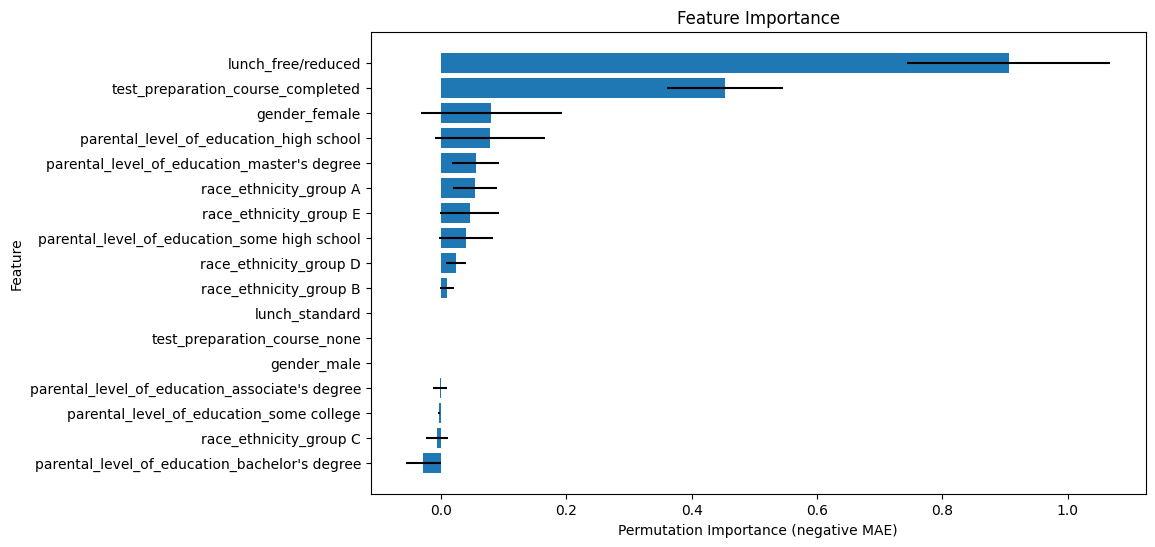

In [45]:
# XGBoost
xgb_model = XGBRegressor(random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

xgb_search = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
xgb_search.fit(X_train, y_train)
xgb_best_model = xgb_search.best_estimator_
print(xgb_search.best_params_)
evaluate_model(xgb_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(xgb_best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
Mean Absolute Error: 9.95198318318721
Mean Squared Error: 153.55572570422794
R-squared: 0.20769102463338296
                                           Feature  Importance       Std
13                              lunch_free/reduced    0.432015  0.080018
14                                  lunch_standard    0.362138  0.063668
15               test_preparation_course_completed    0.158025  0.068903
16                    test_preparation_course_none    0.156737  0.059084
9          parental_level_of_education_high school    0.087475  0.086485
2                           race_ethnicity_group A    0.065341  0.042117
10     parental_level_of_education_master's degree    0.065101  0.045922
12    parental_level_of_education_some high school    0.037554  0.039806
6                           race_ethnicity_group E    0.035399  0.040781
5                     

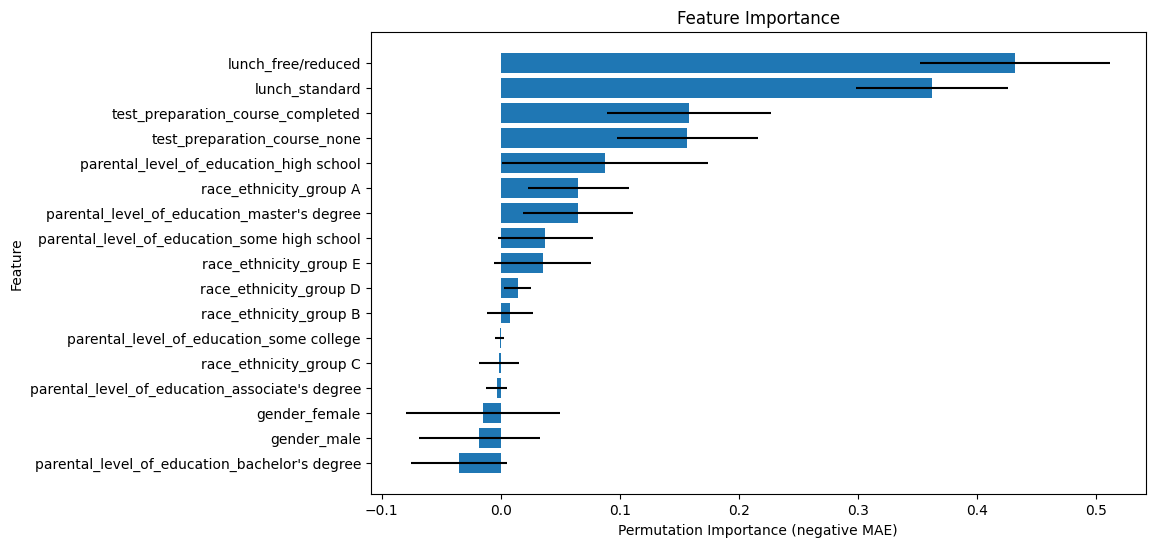

In [46]:
# Gradient Boosting
gbm_model = GradientBoostingRegressor(random_state=42)

param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

gbm_search = RandomizedSearchCV(gbm_model, param_grid_gbm, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
gbm_search.fit(X_train, y_train)
gbm_best_model = gbm_search.best_estimator_
print(gbm_search.best_params_)
evaluate_model(gbm_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(gbm_best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'kernel': 'linear', 'gamma': 'auto', 'C': 10}
Mean Absolute Error: 9.849557993984924
Mean Squared Error: 148.93416287265444
R-squared: 0.2315371280260331
                                           Feature  Importance       Std
13                              lunch_free/reduced    0.391400  0.064891
14                                  lunch_standard    0.391400  0.064891
2                           race_ethnicity_group A    0.155888  0.075367
6                           race_ethnicity_group E    0.119479  0.075840
5                           race_ethnicity_group D    0.104000  0.030771
9          parental_level_of_education_high school    0.103423  0.120225
16                    test_preparation_course_none    0.073162  0.103398
15               test_preparation_course_completed    0.073162  0.103398
10     parental_level_of_education_master's degree    0.060942  0.050696
12    parental_level_of_education_some high school    

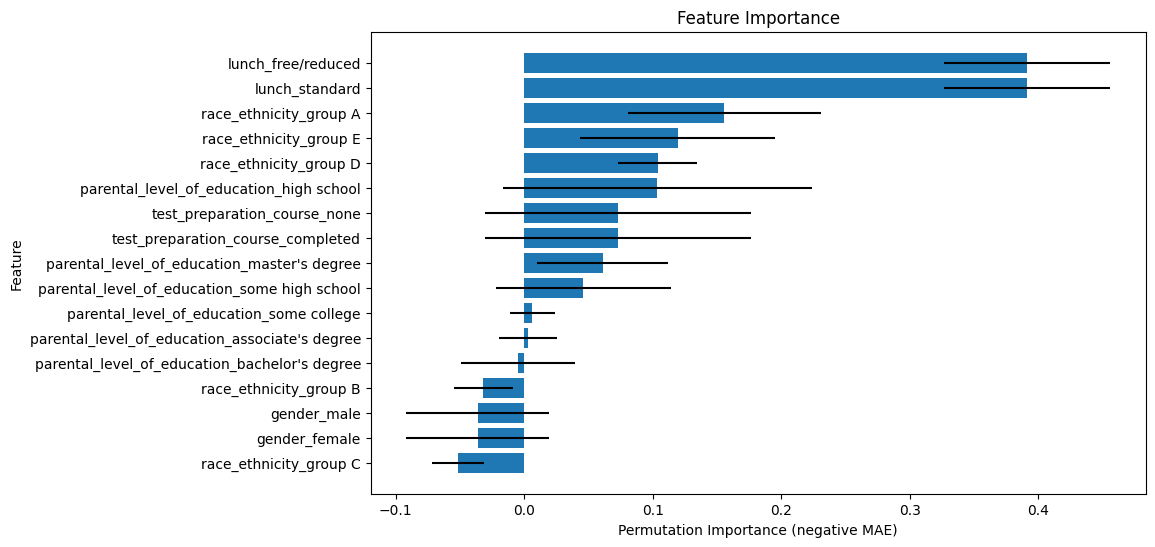

In [47]:
# Support Vector Regressor
svr_model = SVR()

param_grid_svr = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

svr_search = RandomizedSearchCV(svr_model, param_grid_svr, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
svr_search.fit(X_train, y_train)
svr_best_model = svr_search.best_estimator_
print(svr_search.best_params_)
evaluate_model(svr_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(svr_best_model)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'alpha': 0.1, 'l1_ratio': 0.5}
Mean Absolute Error: 9.864355287382052
Mean Squared Error: 149.0131034407164
R-squared: 0.23112981452268322
                                           Feature  Importance       Std
13                              lunch_free/reduced    0.389095  0.060135
14                                  lunch_standard    0.388956  0.060117
15               test_preparation_course_completed    0.107726  0.083545
16                    test_preparation_course_none    0.107637  0.083516
9          parental_level_of_education_high school    0.091451  0.109163
6                           race_ethnicity_group E    0.087471  0.055763
2                           race_ethnicity_group A    0.064570  0.031418
5                           race_ethnicity_group D    0.050910  0.024024
10     parental_level_of_education_master's degree    0.035651  0.025443
12    parental_level_of_education_some high school    0.022378  0.0445

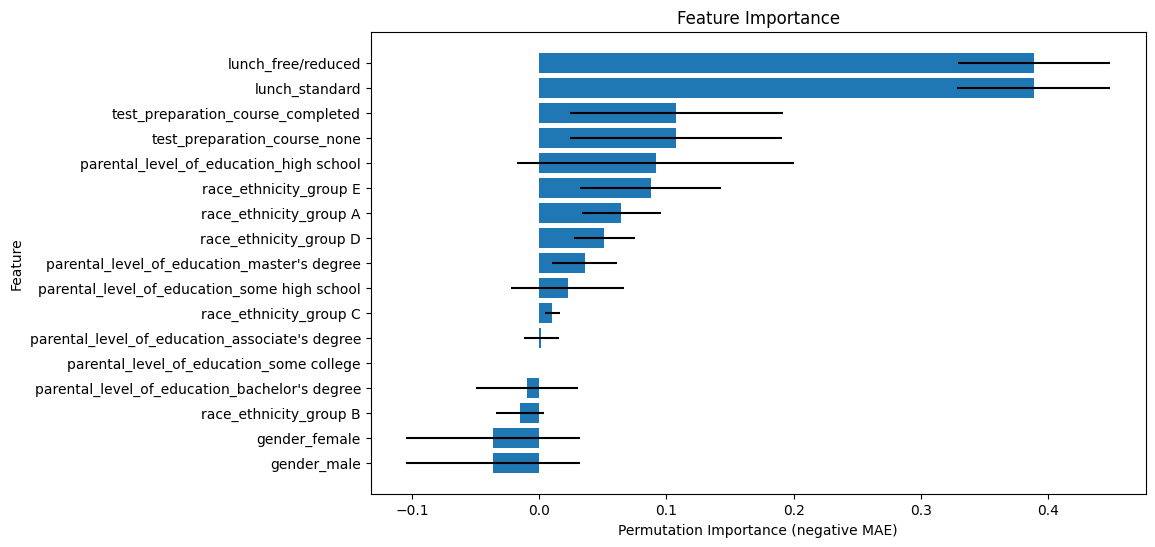

In [48]:
# Elastic Net
en_model = ElasticNet(random_state=42)

param_grid_en = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

en_search = GridSearchCV(en_model, param_grid_en, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')
en_search.fit(X_train, y_train)
en_best_model = en_search.best_estimator_
print(en_search.best_params_)
evaluate_model(en_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(en_best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'weights': 'uniform', 'n_neighbors': 7, 'metric': 'manhattan'}
Mean Absolute Error: 10.675041876046897
Mean Squared Error: 182.14668581000237
R-squared: 0.060168851804823675
                                           Feature  Importance       Std
13                              lunch_free/reduced    0.339890  0.123812
14                                  lunch_standard    0.339890  0.123812
10     parental_level_of_education_master's degree    0.092965  0.081240
3                           race_ethnicity_group B    0.068294  0.119364
9          parental_level_of_education_high school    0.060732  0.174556
0                                    gender_female    0.052094  0.091085
1                                      gender_male    0.052094  0.091085
4                           race_ethnicity_group C    0.047093  0.170279
6                           race_ethnicity_group E   -0.046853  0.131753
5                           race_e

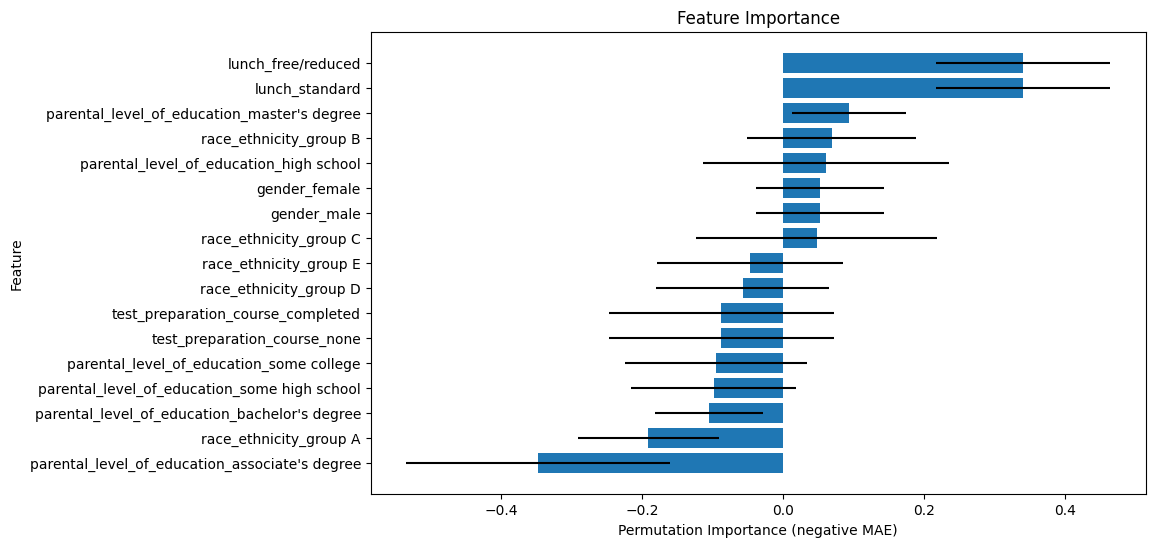

In [49]:
# K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_search = RandomizedSearchCV(knn_model, param_grid_knn, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
knn_search.fit(X_train, y_train)
knn_best_model = knn_search.best_estimator_
print(knn_search.best_params_)
evaluate_model(knn_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(knn_best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 4, 'bootstrap': True}
Mean Absolute Error: 9.827087815824509
Mean Squared Error: 151.28747813139748
R-squared: 0.21939461238346603
                                           Feature  Importance       Std
14                                  lunch_standard    0.456232  0.088748
13                              lunch_free/reduced    0.380051  0.083833
15               test_preparation_course_completed    0.164738  0.079333
9          parental_level_of_education_high school    0.115159  0.102129
16                    test_preparation_course_none    0.088426  0.070976
10     parental_level_of_education_master's degree    0.084380  0.038106
12    parental_level_of_education_some high school    0.053109  0.027824
2                           race_ethnicity_group A    0.039404  0.032837
5                           race_ethnicity_group D    0.021642  0.02

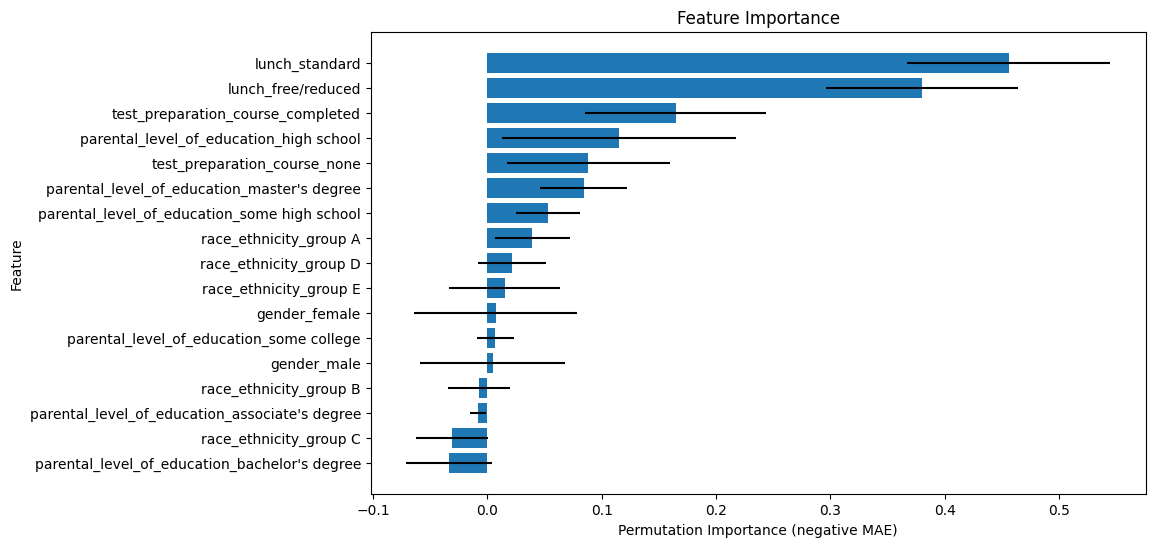

In [50]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(rf_model, param_grid_rf, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
rf_search.fit(X_train, y_train)
rf_best_model = rf_search.best_estimator_
print(rf_search.best_params_)
evaluate_model(rf_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(rf_best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 100, 'learning_rate': 0.1}
Mean Absolute Error: 9.873029846679819
Mean Squared Error: 151.14353169216554
R-squared: 0.22013733985424244
                                           Feature  Importance       Std
13                              lunch_free/reduced    0.361424  0.100667
14                                  lunch_standard    0.266650  0.090271
15               test_preparation_course_completed    0.117421  0.088325
9          parental_level_of_education_high school    0.094146  0.094567
5                           race_ethnicity_group D    0.037340  0.021648
16                    test_preparation_course_none    0.033902  0.088023
4                           race_ethnicity_group C    0.013860  0.032312
12    parental_level_of_education_some high school    0.013358  0.032329
10     parental_level_of_education_master's degree    0.012243  0.019161
6                           race_ethnicity_group E    0.

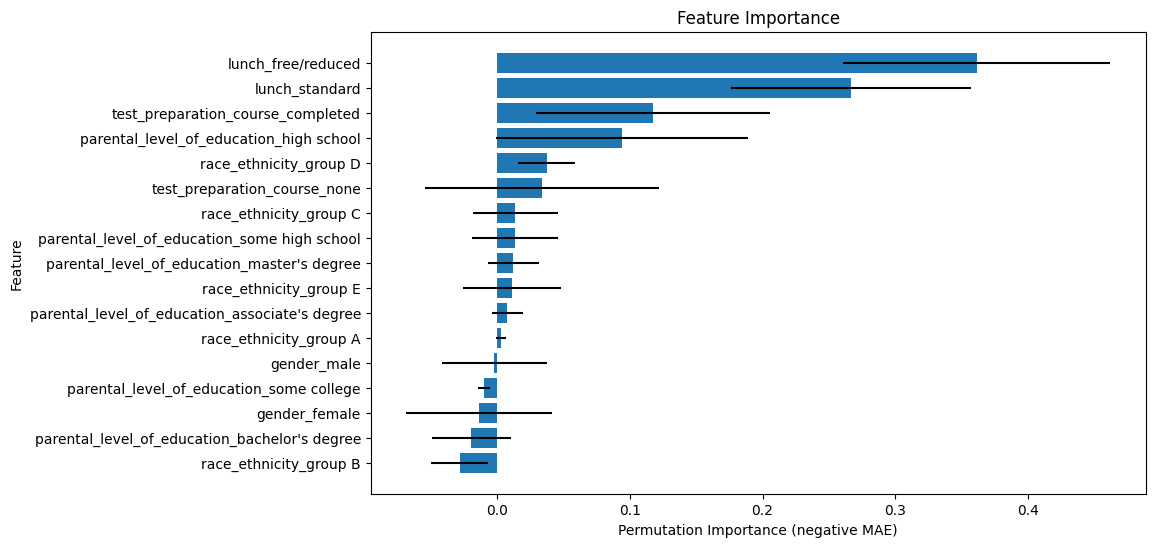

In [51]:
# AdaBoost Regressor
ada_model = AdaBoostRegressor(random_state=42)

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

ada_search = RandomizedSearchCV(ada_model, param_grid_ada, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)
ada_search.fit(X_train, y_train)
ada_best_model = ada_search.best_estimator_
print(ada_search.best_params_)
evaluate_model(ada_best_model, X_train, X_test, y_train, y_test)
calculateFeatureImportance(ada_best_model)

In [ ]:
import joblib

# Saving the model to a file
joblib_file = 'final_model.pkl'
joblib.dump(rf_best_model, joblib_file)
print(f'Model saved to {joblib_file}')

Model saved to final_model.pkl
